In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
RX_pattern = np.load('data/RX_pattern.npy')
TX_pattern = np.load('data/TX_pattern.npy')
OMNI_pattern = np.load('data/OMNI_pattern.npy')
impulse_response = np.load('data/impulse_response.npy')
#print(impulse_response)

In [3]:
def horzontal_shift(angle): 
    if angle > 0:
        horizontal1 = TX_pattern[:,-angle:]
        horizontal2 = TX_pattern[:,:-angle]
        shifted_pattern = np.hstack((horizontal1, horizontal2))
        
    elif angle < 0:
        horizontal1 = TX_pattern[:,-(360+angle):]
        horizontal2 = TX_pattern[:,:-(360+angle)]
        shifted_pattern = np.hstack((horizontal1, horizontal2))
        
    else:
        shifted_pattern = TX_pattern  

    return shifted_pattern

In [4]:
def vertical_shift(angle): 
    RX_vertical1 = RX_pattern[-90:, :]
    RX_vertical2 = RX_pattern[:-90, :]
    RX_pattern = np.vstack((RX_vertical1, RX_vertical2))

In [5]:
all_paths = impulse_response.shape[0]
angles = [-90,-60,-45,-30,-15,0,15,30,45,60,90]
horizontal_sweep = np.zeros((all_paths, len(angles)+1))
a = np.zeros((all_paths, len(angles)))
i = 0

for angle in angles:
    TX_pattern_shifted = horzontal_shift(angle)
    
    for path_idx in range(all_paths):
        TX1 = int(impulse_response[path_idx][3])
        TX2 = int(impulse_response[path_idx][4])
        RX1 = int(impulse_response[path_idx][5])
        RX2 = int(impulse_response[path_idx][6])

        horizontal_sweep[path_idx][0] = impulse_response[path_idx][2]
        horizontal_sweep[path_idx][(i+1)] = 20*np.log10(impulse_response[path_idx][1])
        horizontal_sweep[path_idx][(i+1)] = horizontal_sweep[path_idx][(i+1)] + TX_pattern_shifted[TX1][TX2] + OMNI_pattern[RX1][RX2]
        #impulse_response[path_idx][(i+1)] = horizontal_sweep[path_idx][(i+1)] + TX_pattern_shifted[TX1][TX2] + RX_pattern[RX1][RX2]
        horizontal_sweep[path_idx][(i+1)] = 10**(horizontal_sweep[path_idx][(i+1)]/20)

        a[path_idx][i] = TX_pattern_shifted[TX1][TX2]
        
    i = i + 1
    
#print(horizontal_sweep)

In [6]:
def angles_shift(angle): 
    if angle > 0:
        angle_axis = np.concatenate((angle_vector[-(360-angle):], angle_vector[:-(360-angle)])) 
    elif angle < 0:
        angle_axis = np.concatenate((angle_vector[-(-angle):], angle_vector[:-(-angle)]))
    else:
        angle_axis = angle_vector

    return angle_axis

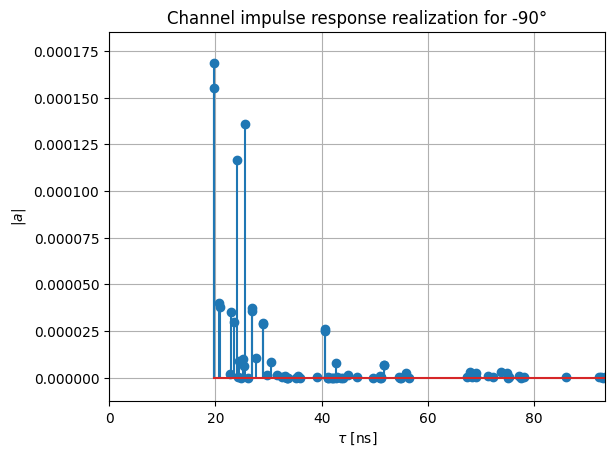

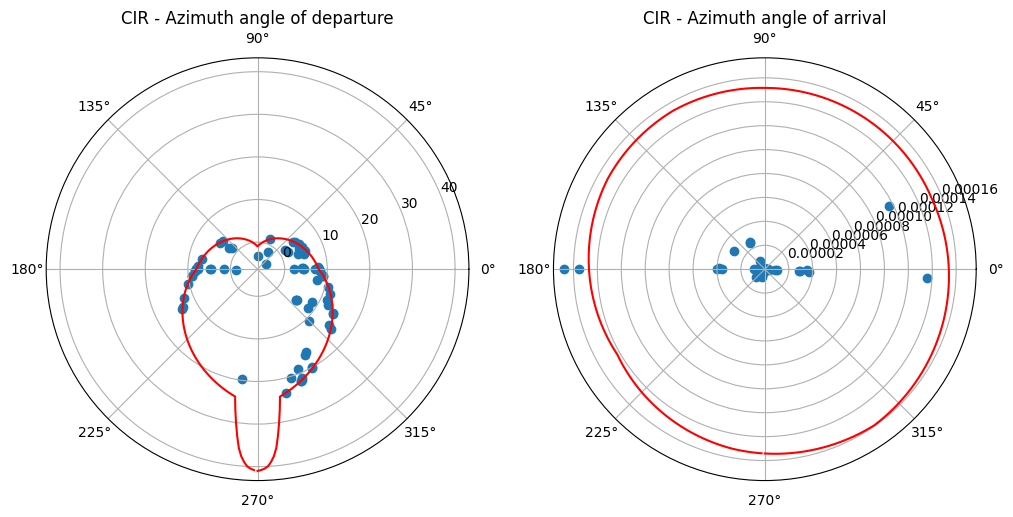

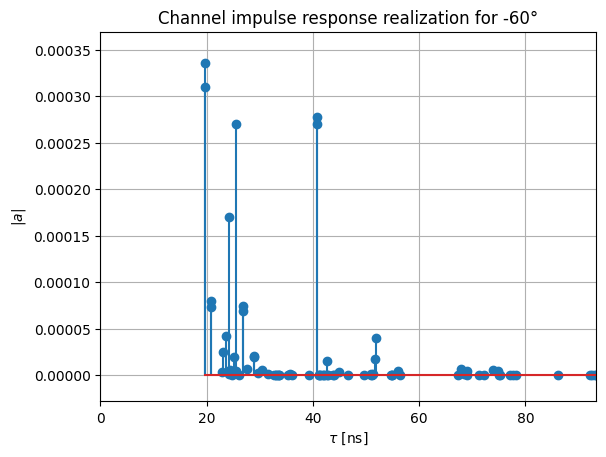

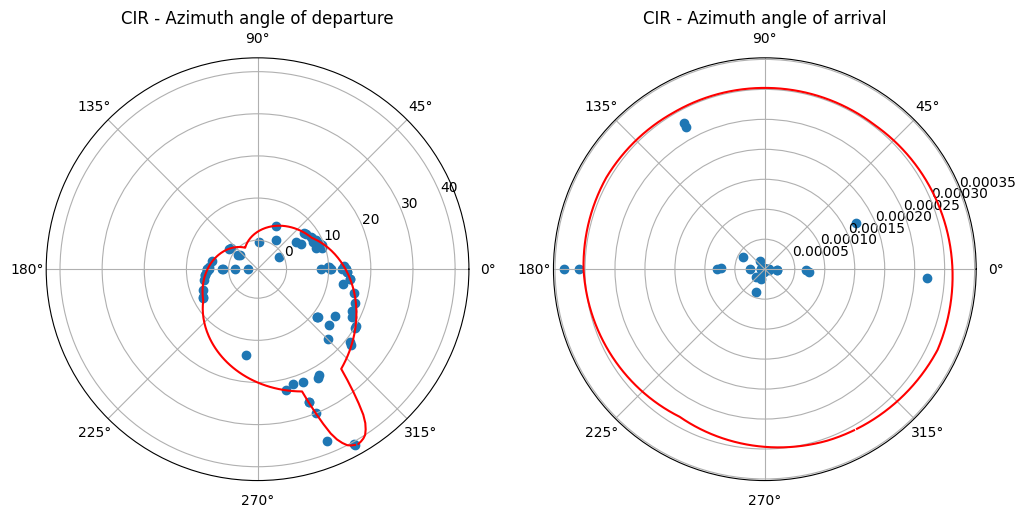

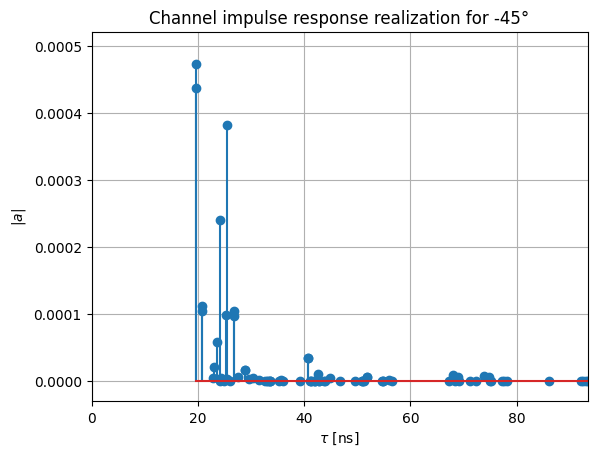

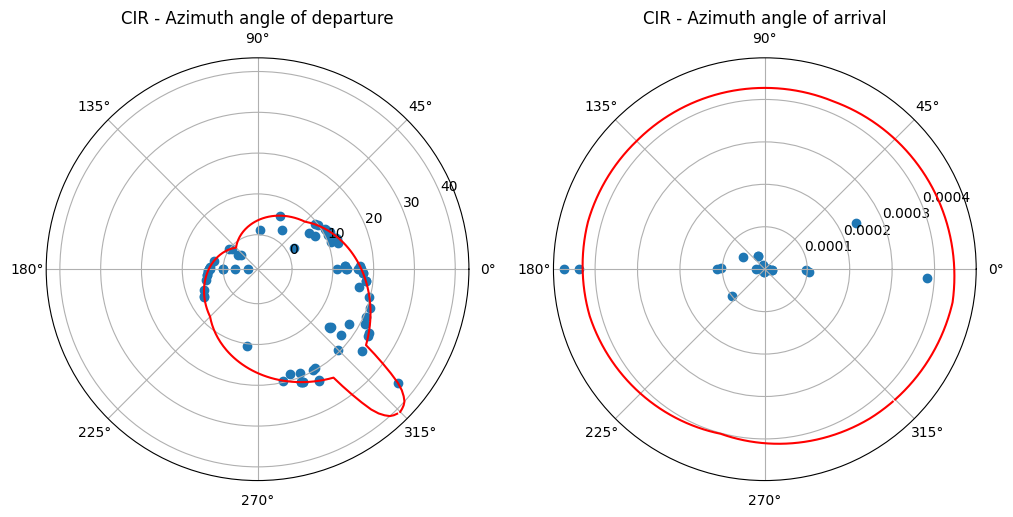

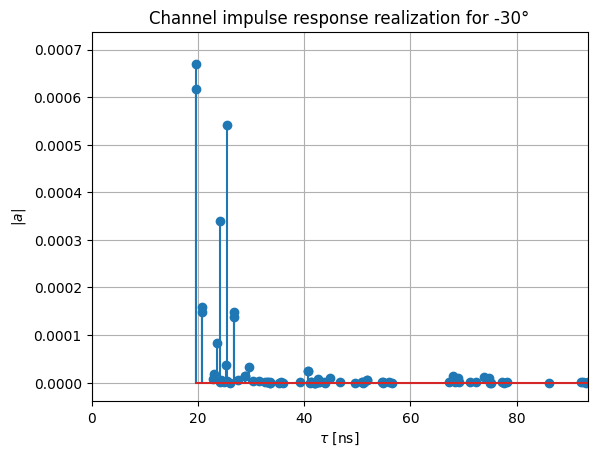

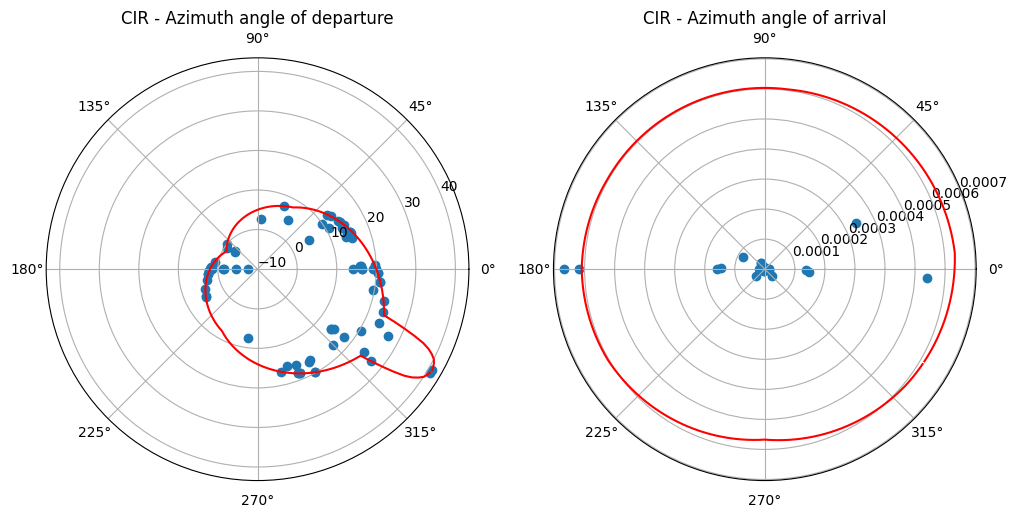

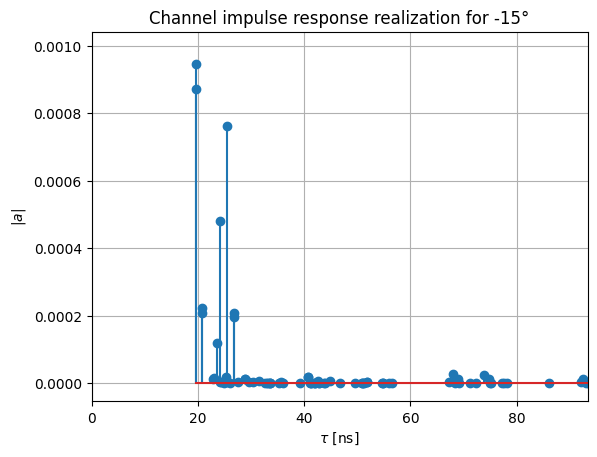

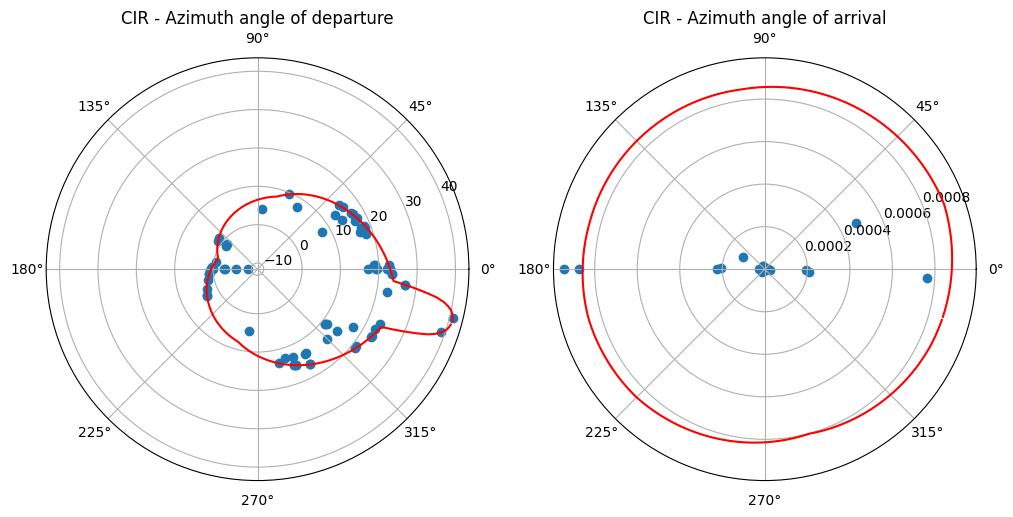

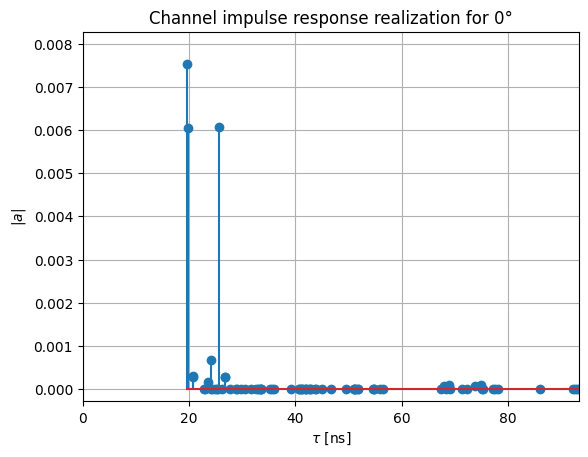

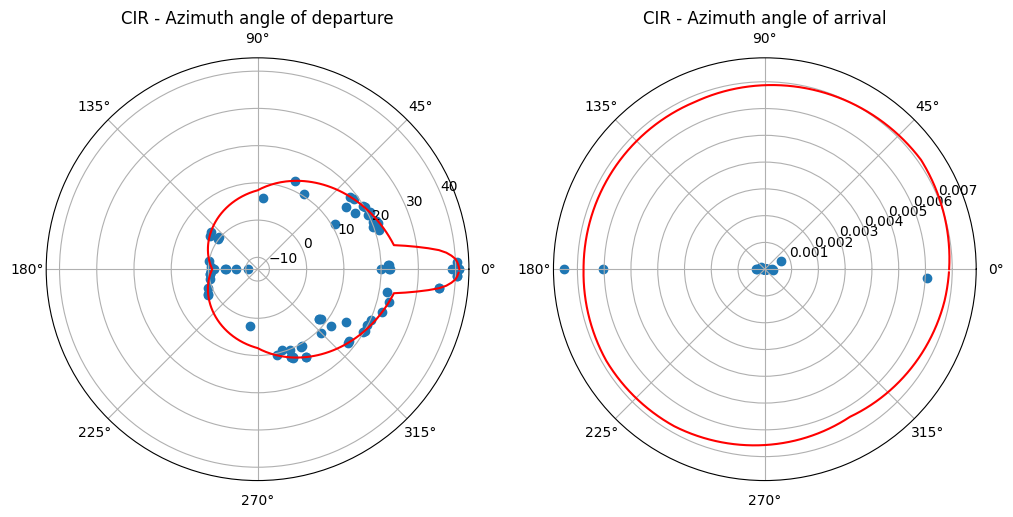

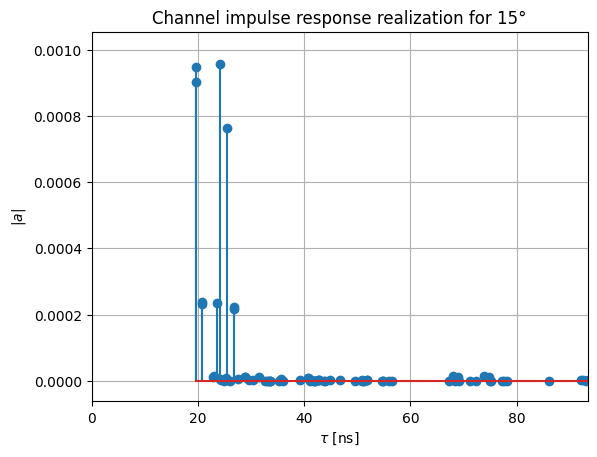

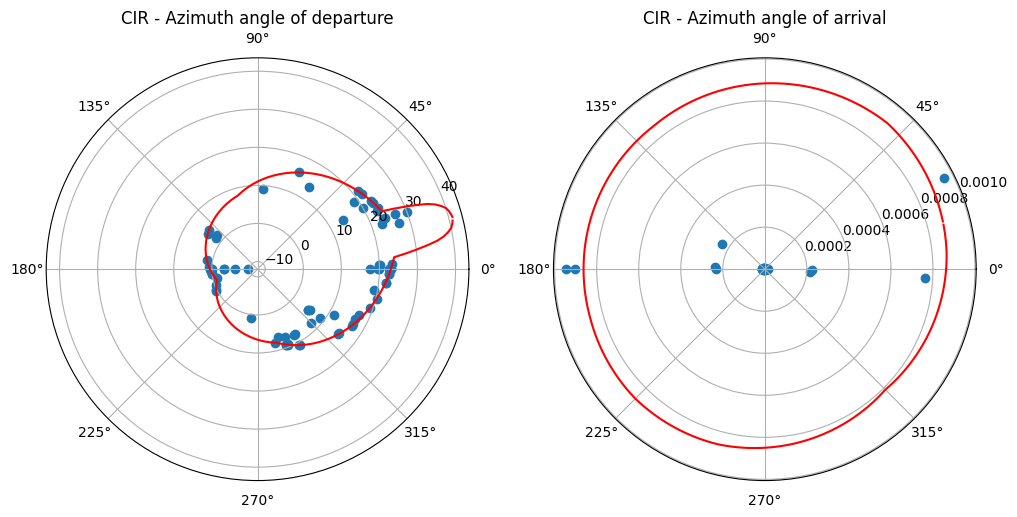

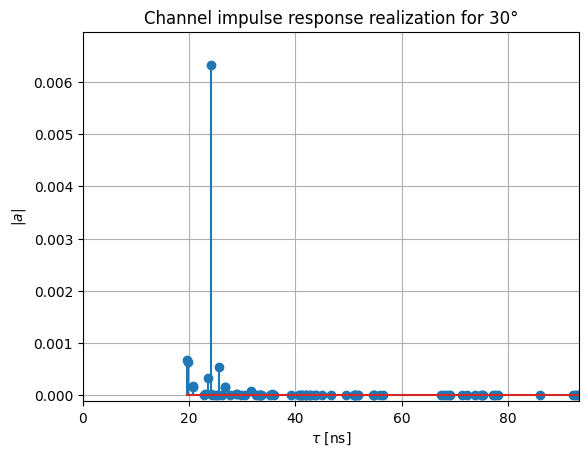

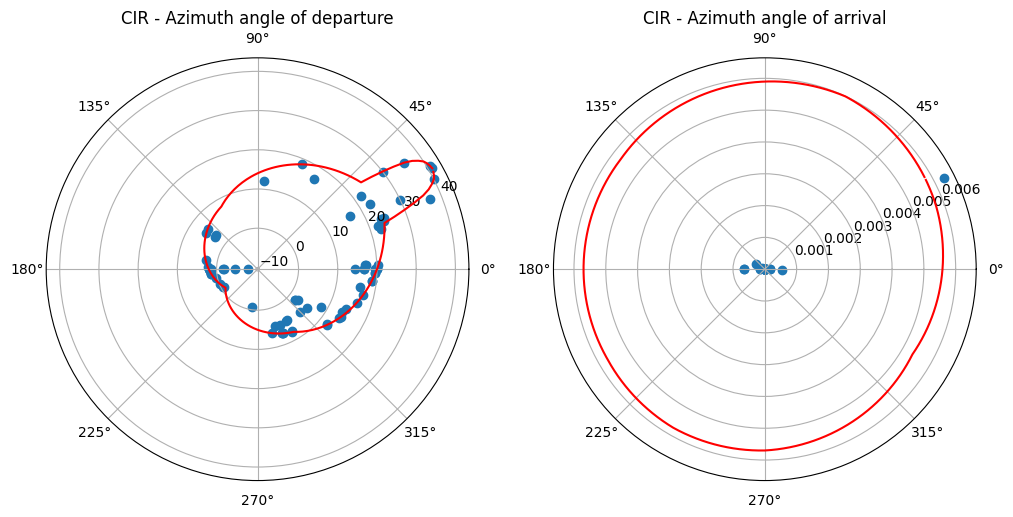

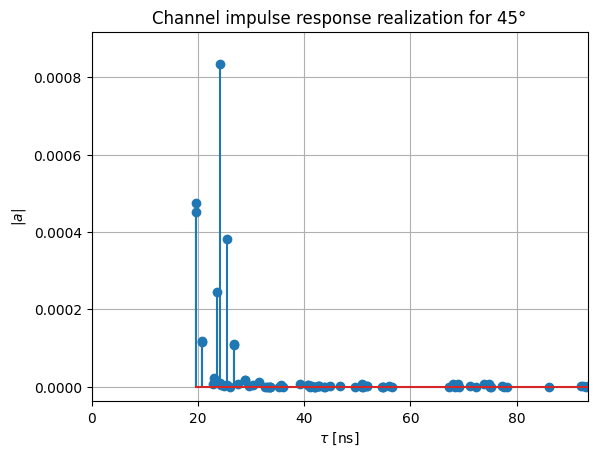

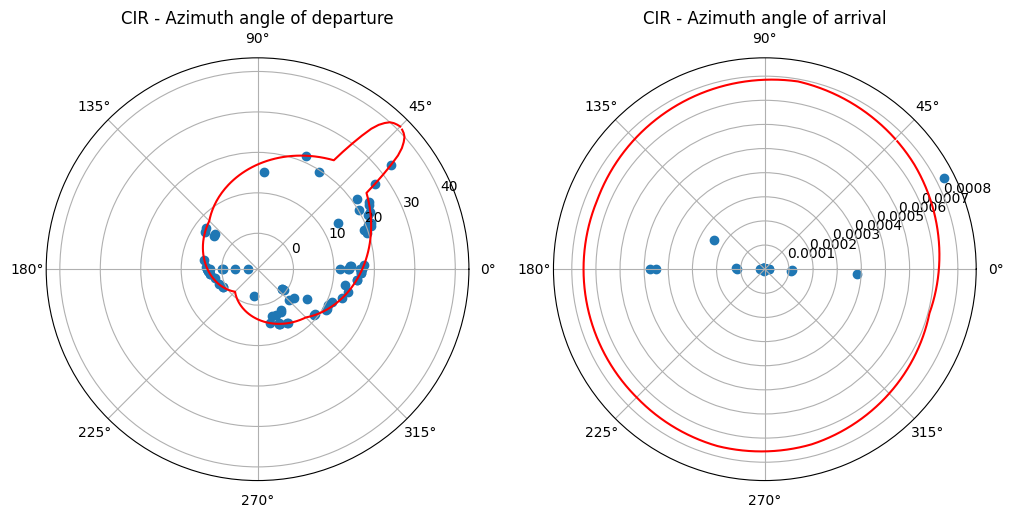

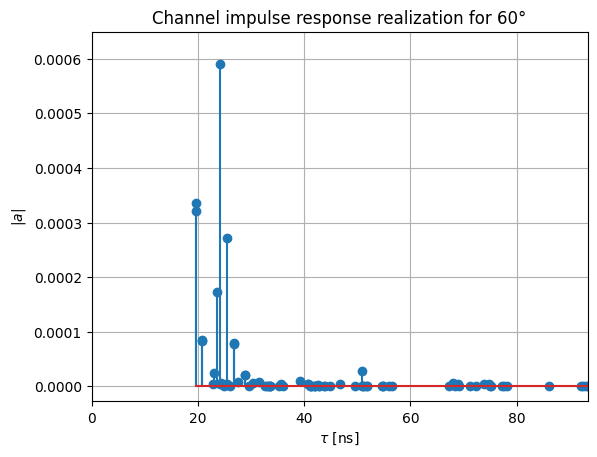

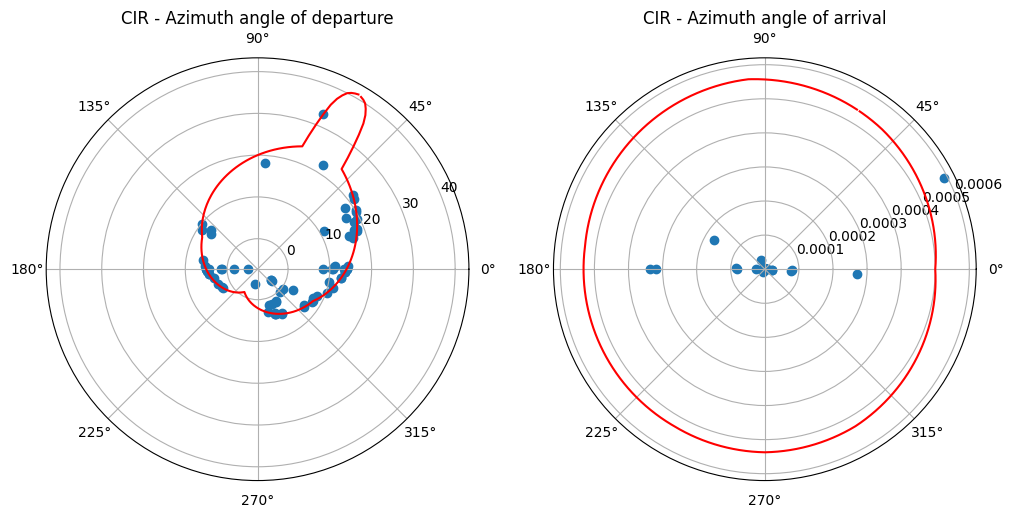

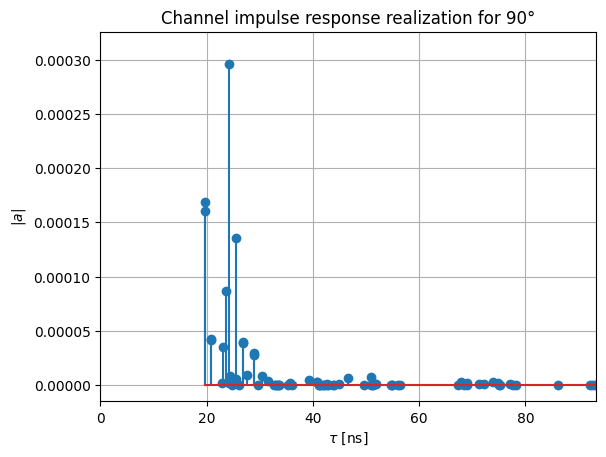

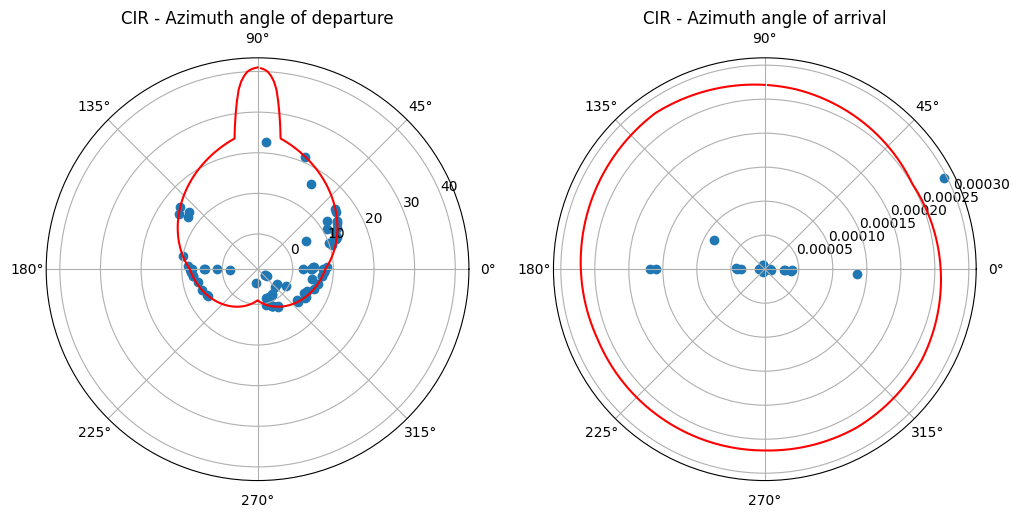

In [7]:
t = horizontal_sweep[:,0]/1e-9
angle_vector = np.linspace(0, 359, num=360)*np.pi/180
i=0

for angle in angles: 
    angle_axis = angles_shift(angle)  
  
    # CIR time domain
    plt.figure()
    plt.title("Channel impulse response realization for " + str(int(angle)) + "°")
    plt.stem(t, horizontal_sweep[:,(i+1)])
    plt.xlim([0, np.max(t)])
    plt.ylim([-np.average(horizontal_sweep[:,(i+1)]), np.max(horizontal_sweep[:,(i+1)])*1.1])
    plt.xlabel(r"$\tau$ [ns]")
    plt.ylabel(r"$|a|$");
    plt.grid()

    # CIR angle domain
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

    # Plot on the first subplot
    ax1.scatter(impulse_response[:, 4] * np.pi / 180, a[:,i], label='CIR')
    ax1.plot(angle_axis, TX_pattern[90, :], color='red')
    ax1.set_title("CIR - Azimuth angle of departure")
    ax1.grid(True)

    # Plot on the second subplot
    ax2.scatter(impulse_response[:,6]*np.pi/180, horizontal_sweep[:,(i+1)])
    ax2.set_title("CIR - Azimuth angle of arrival")
    ax2.grid(True)

    ax2_secondary = fig.add_axes(ax2.get_position(), projection='polar')
    ax2_secondary.plot(angle_axis, OMNI_pattern[90, :], color='red')
    ax2_secondary.set_frame_on(False)  # Remove the frame
    ax2_secondary.yaxis.set_visible(False)  # Hide secondary axis ticks and labels
    ax2_secondary.xaxis.set_visible(False)  # Optionally hide angular axis
    ax2_secondary.set_ylim(-30, 5)

    # Show the plots
    plt.show()

    i = i + 1

In [8]:
# Define parameters
num_tx_antennas = 1  # Number of transmit antennas
num_rx_antennas = 1  # Number of receive antennas
num_beams = 10  # Number of beams in the codebook

# Generate a sample codebook with beams as phase shifts
def generate_codebook(num_tx_antennas, num_beams):
    codebook = []
    for i in range(num_beams):
        phase_shift = np.exp(1j * 2 * np.pi * i / num_beams)  # Phase shift per beam
        beam = np.array([phase_shift ** n for n in range(num_tx_antennas)])
        codebook.append(beam / np.sqrt(num_tx_antennas))  # Normalize power
    return np.array(codebook)

# Generate the codebook
codebook = generate_codebook(num_tx_antennas, num_beams)

# Simulate an example channel matrix
channel = np.random.randn(num_rx_antennas, num_tx_antennas) + 1j * np.random.randn(num_rx_antennas, num_tx_antennas)

# Beamforming process: Evaluate each beam in the codebook
beam_scores = []
for beam in codebook:
    # Compute the beamformed signal by applying beam to the channel
    received_signal = np.dot(channel, beam)
    
    # Calculate the received power (signal strength)
    received_power = np.linalg.norm(received_signal) ** 2
    beam_scores.append(received_power)

# Select the best beam based on maximum received power
best_beam_index = np.argmax(beam_scores)
best_beam = codebook[best_beam_index]

print(f"Best beam index: {best_beam_index}")
print(f"Best beam vector: {best_beam}")
print(f"Maximum received power: {beam_scores[best_beam_index]}")

Best beam index: 0
Best beam vector: [1.+0.j]
Maximum received power: 2.2560275661130795
